### Using the temporal nets to analyse the burst dynamics of links 

Analysis of the burst dynamics of each link for each frequency band and stage of the ODRT.

In [74]:
# Adding GDa to path
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.spectral_analysis import filtering, time_frequency
from   tqdm                              import tqdm
from   joblib                            import Parallel, delayed
from   GDa.graphics.plot_brain_sketch import *
from   GDa.session           import session
from   scipy                             import stats
import numpy                 as     np
import matplotlib.pyplot     as     plt
import scipy.signal
import time

# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Bands names
bands = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [75]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    mu, sigma   = act_lengths.mean(), act_lengths.std()
    return mu, sigma, sigma/mu 

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,7]  Hz;
- $\alpha$  = [8,14]  Hz;
- $\beta$   = [16,34]  Hz;
- low-$\gamma$  = [40,70]  Hz;
- high-$\gamma$  = [70,100]  Hz;

Band ranges from: https://doi.org/10.1016/j.neuron.2016.02.028 

In [76]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(raw_path = '../super_tensors/', monkey='lucy', session=1, date=150128, align_to = 'cue', 
                        trial_type = 1, behavioral_response = 1, trim_borders=True, wt_0=20, wt_1=30)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

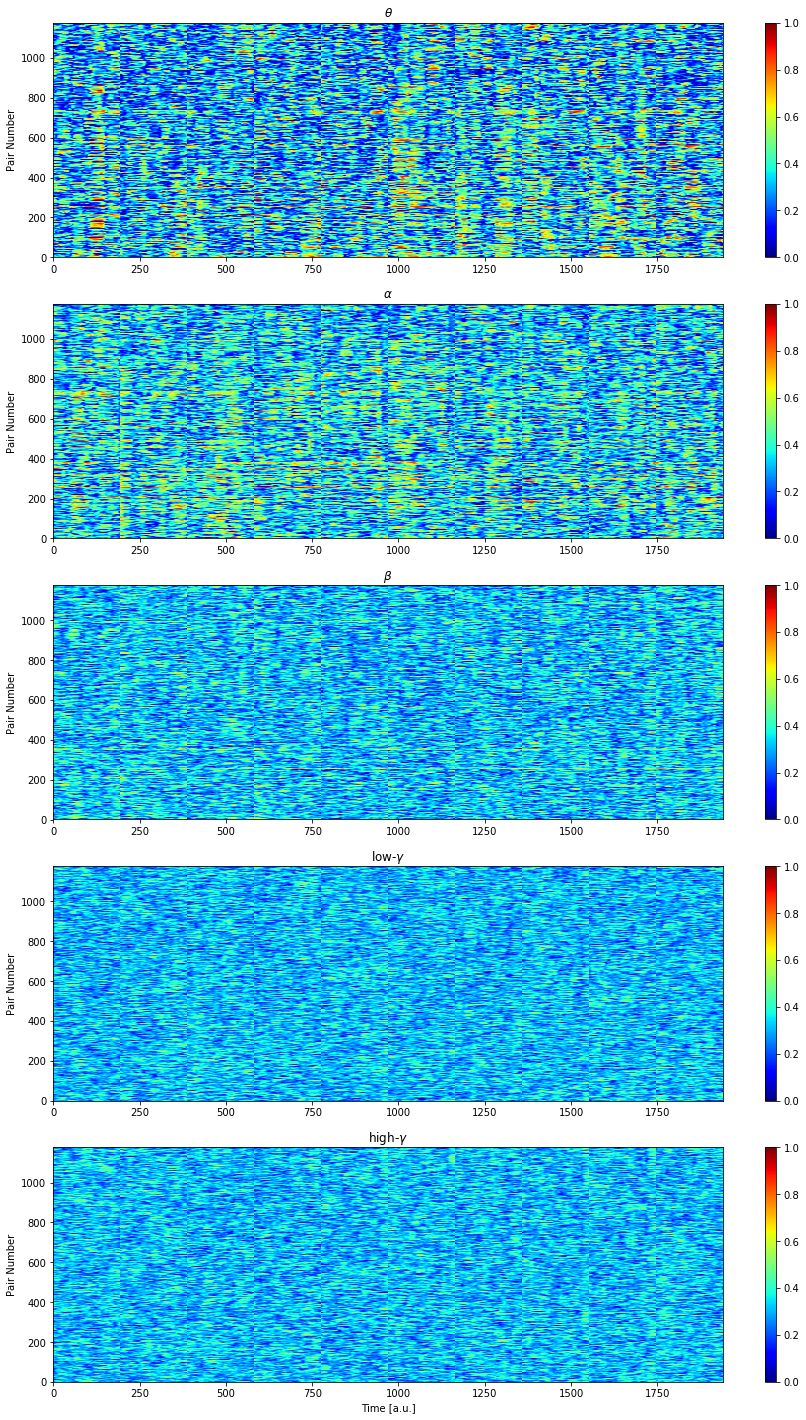

In [77]:
plt.figure(figsize=(15,25))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(net.super_tensor[:,i,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.colorbar()
    plt.ylabel('Pair Number')
    if i == 4: plt.xlabel('Time [a.u.]')
    plt.title(bands[i])

Before moving the measures and preliminary results, during the analysis we may be interested to separate the measures we make by task stage, to do so we need some way to acess our arrays (super_tensor, adjacency matrix, node_degree...) in an specific stage. Using the method __create_stages_time_grid__, four array will be created inside the object: __t_baseline__, __t_cue__, __t_delay__, and __t_match__. Using those array any stage can be acessed easily, let's suposse you want the super tensor values only for the delay period in alpha band, you can retrieve this values by doing:

```net.super_tensor[:,1,net.t_baseline] ```

In [78]:
# Creating stages grid
net.create_stages_time_grid()

Text(0.5, 1.0, 'Yellow = Baseline, Green = Cue, Blue = Delay, Purple = Match')

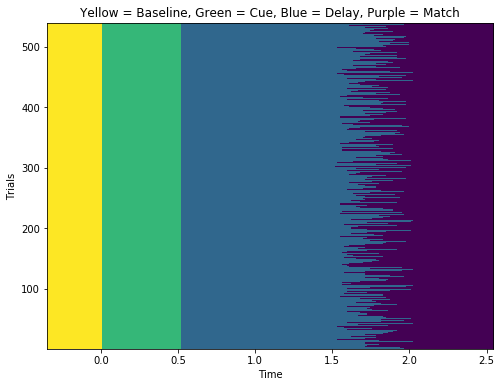

In [79]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]
    
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower', extent=[net.tarray[0],net.tarray[-1],1,net.session_info['nT']])
plt.ylabel('Trials')
plt.xlabel('Time')
plt.title('Yellow = Baseline, Green = Cue, Blue = Delay, Purple = Match')

Similarly to separating the measurements by task stage, we could be insterested in separating them by cue type (i.e., by differenciating the cue presented to the monkey), to create the grid which allows us to acess trials were a specific cue was presented to the monkey the method __create_stim_grid__. This method will create an array named __stim_grid__ inside the __temporal_network__ object, this array will have the shape [Number of cues, Trials * Time]. Let's suposse you want the super tensor values in the alpha band only for the second cue type presented, you can retrieve this values by doing:

```net.super_tensor[:,1,net.stim_grid[1]] ```

In [80]:
net.create_stim_grid()

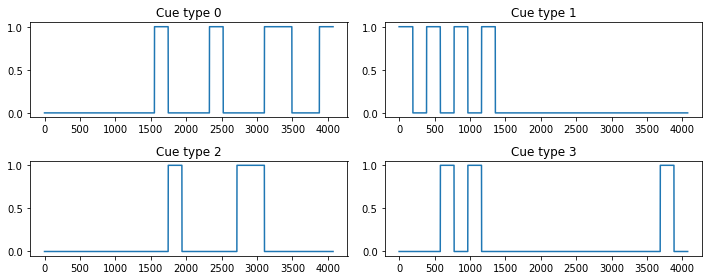

In [81]:
plt.figure(figsize=(10,4))
for i in range(net.stim_grid.shape[0]-1):
    plt.subplot(2,2,i+1)
    plt.plot(net.stim_grid[i,:21*len(net.tarray)])
    plt.title('Cue type ' + str(i))
plt.tight_layout()

### Thresholding 

To do the burstiness analysis it is necessary to define thresholds to the links' weights. The weights can be absolute, i.e., estimated on the pooled data for each frequency band or relative, i.e., computed separately for each link.

### Absolute thresholding


Some of the network theory measures can be applied to the binarized version of the network and in order to do so it is necessary to define thresholds for the coherence values, this can be done with the method __compute_coherence_thresholds__, this method receives a parameter __q__ between $0$ and $1$ that specifies that only links with coherence values in the top $(1-q)$ of the distribution will be kept.

Threshold in $\delta$ band = 0.5004674047231674
Threshold in $\alpha$ band = 0.48368224047124386
Threshold in $\beta$  band = 0.3963930446902911
Threshold in low-$\gamma$ band = 0.3766733191721141
Threshold in high-$\gamma$ band = 0.37561105037108067


Text(0.5, 1.0, 'q = 0.8')

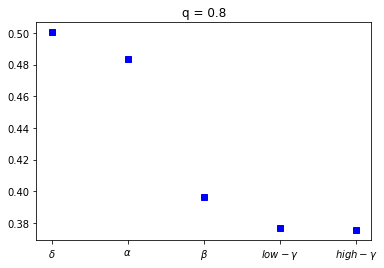

In [9]:
q_thr = 0.80
net.compute_coherence_thresholds(q = q_thr)

# Printing the threshold values 
print(r'Threshold in $\delta$ band = ' + str(net.coh_thr[0]))
print(r'Threshold in $\alpha$ band = ' + str(net.coh_thr[1]))
print(r'Threshold in $\beta$  band = ' + str(net.coh_thr[2]))
print(r'Threshold in low-$\gamma$ band = ' + str(net.coh_thr[3]))
print(r'Threshold in high-$\gamma$ band = ' + str(net.coh_thr[4]))

plt.plot(range(5), net.coh_thr, 'bs')
plt.xticks(range(5), [r'$\delta$', r'$\alpha$', r'$\beta$', r'$low-\gamma$', r'$high-\gamma$'])
plt.title('q = ' + str(q_thr))

To better visualize the threshold we can plot the pooled ditributions of coherence for each frequency band and indicate the threshold with a vertical line:

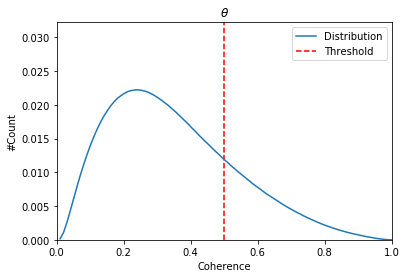

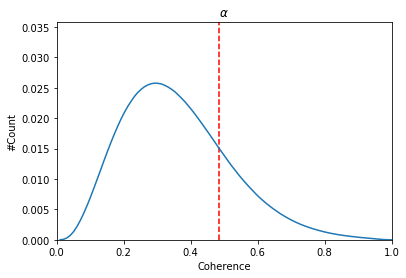

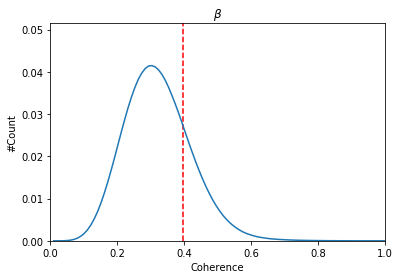

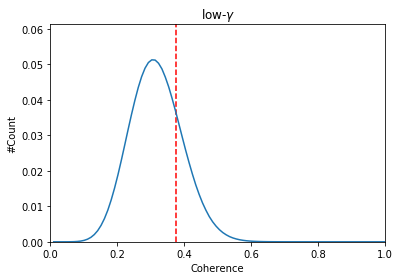

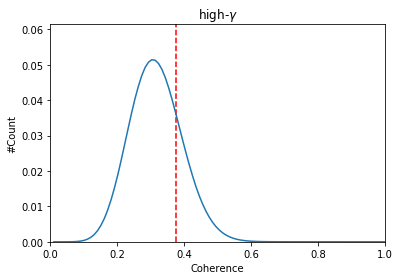

In [10]:
for i in range(len(bands)):
    plt.figure()
    n,x = np.histogram(net.super_tensor[:,i,:].flatten(order = 'C'), bins=np.linspace(0,1,100))
    n = n / n.sum()
    plt.ylabel('#Count')
    plt.xlabel('Coherence')
    plt.title(bands[i])
    plt.plot(x[1:], n)
    plt.xlim([0,1])
    plt.ylim([0, n.max() + 0.01])
    if type(net.coh_thr[i]) != type(None):
        plt.vlines(net.coh_thr[i], 0, n.max() + 0.01, linestyle = '--', color = 'r')
        if i == 0:
            plt.legend(['Distribution', 'Threshold'])

Let's plot the binarized super tensor as well:

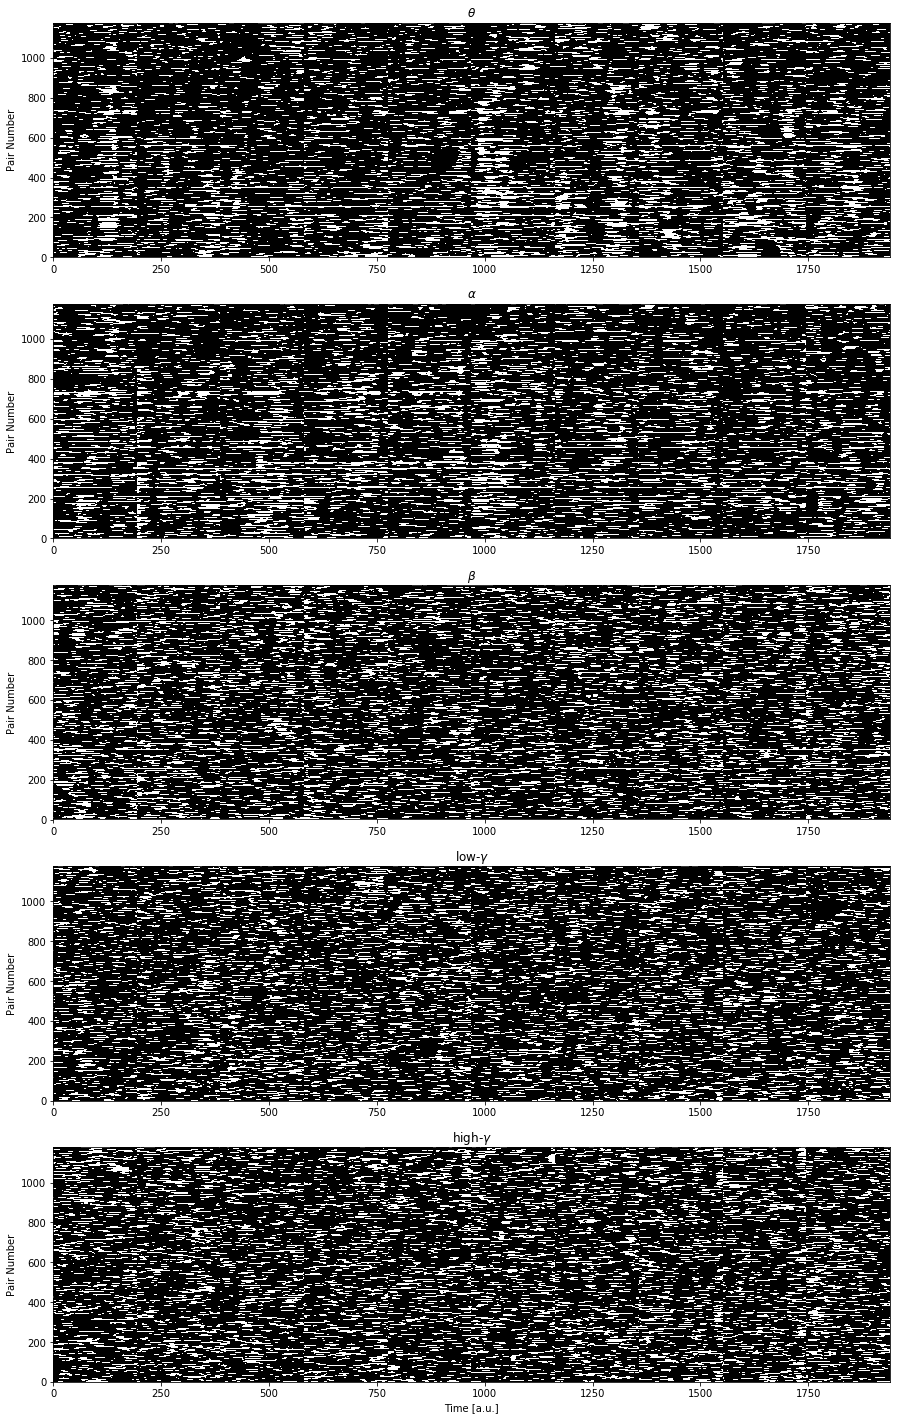

In [11]:
plt.figure(figsize=(15,25))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(net.super_tensor[:,i,:10*len(net.tarray)]>net.coh_thr[i], aspect = 'auto', cmap = 'gray', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.ylabel('Pair Number')
    if i == 4: plt.xlabel('Time [a.u.]')
    plt.title(bands[i])

In [12]:
# Thresholded super tensor
STb = np.zeros_like(net.super_tensor)
for i in tqdm(range(len(net.bands))):
    STb[:,i,:] = net.super_tensor[:,i,:] > net.coh_thr[i]

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


In [13]:
stages = ['baseline', 'cue', 'delay', 'match']
t_mask = [net.t_baseline, net.t_cue, net.t_delay, net.t_match]
b  = {}

for i in tqdm(range(len(stages))):
    b[stages[i]]  = np.zeros([STb.shape[0], 3])
    b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,1,t_mask[i]])

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


100%|██████████| 4/4 [00:00<00:00, 190.40it/s]


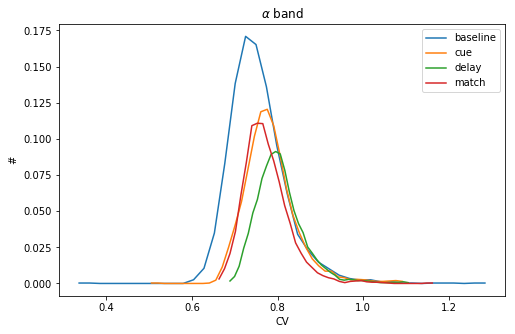

In [14]:
plt.figure(figsize=(8,5))
for i in tqdm(range(len(stages))):
    c, x = np.histogram(b[stages[i]][:,2], 40)
    c    = c/c.sum()
    plt.plot(x[1:], smooth(c, 3), label = stages[i])
plt.ylabel('$\#$')
plt.xlabel('CV')
plt.title(r'$\alpha$ band')
plt.legend()

100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


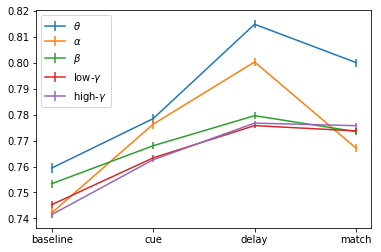

In [15]:
for j in range(len(bands)):
    for i in tqdm(range(len(stages))):
        b[stages[i]]  = np.zeros([STb.shape[0], 3])
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])

    p=b['baseline'][:,2]
    c=b['cue'][:,2]
    d=b['delay'][:,2]
    m=b['match'][:,2]

    plt.errorbar(range(4), [p.mean(), c.mean(), d.mean(), m.mean()], 
                 [p.std()/np.sqrt(1176), c.std()/np.sqrt(1176), d.std()/np.sqrt(1176), m.std()/np.sqrt(1176)])
    plt.xticks(range(4), ['baseline', 'cue', 'delay', 'match'])
plt.legend(bands)

In [16]:
CVm = np.zeros([49, 49, len(bands), len(stages)]) 
b['delay'].shape
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        aux  = np.apply_along_axis( count_activations, 1, STb[:,k,t_mask[i]])
        for j in range( net.session_info['pairs'].shape[0]):
            CVm[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], k, i] = aux[j,2]

100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


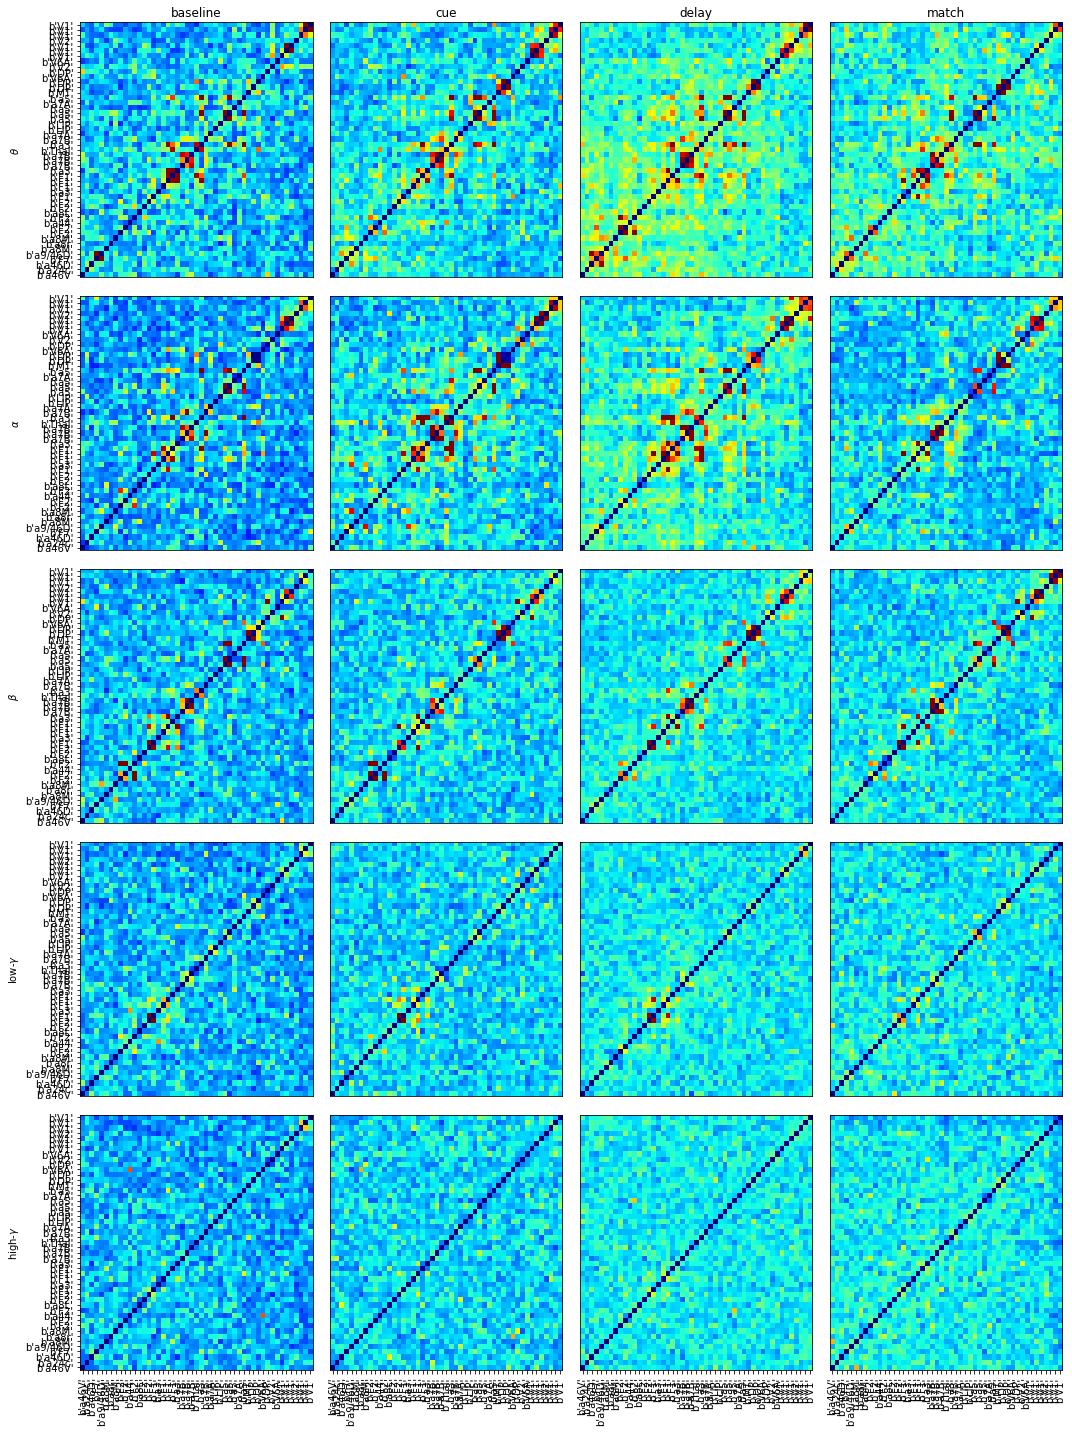

In [17]:
plt.figure(figsize=(15,20))
count = 1
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(bands),len(stages),count)
        aux = (CVm[:,:,k,i]+CVm[:,:,k,i].T) 
        plt.imshow(aux**4, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1)
        if stages[i] == 'baseline': plt.yticks(range(49), net.session_info['areas'])
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), net.session_info['areas'], rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[k])
        #plt.colorbar()
        count+=1
plt.tight_layout()

In [18]:
def plot_edge_brain_sketch(edge_list, node_list, edge_width, edge_color='b'):
    plt.imshow(ethyl_brainsketch)
    for i in range(edge_list.shape[0]):
        c1, c2 = node_list[edge_list[i,0]], node_list[edge_list[i,1]]
        p1  = [xy[c1-1,0], xy[c2-1,0]]
        p2  = [xy[c1-1,1], xy[c2-1,1]]
        plt.plot(p1, p2, '.-', color = edge_color, lw = edge_width[i])
    plt.xticks([])
    plt.yticks([])

#### Top 20 most active links

100%|██████████| 5/5 [01:03<00:00, 12.73s/it]


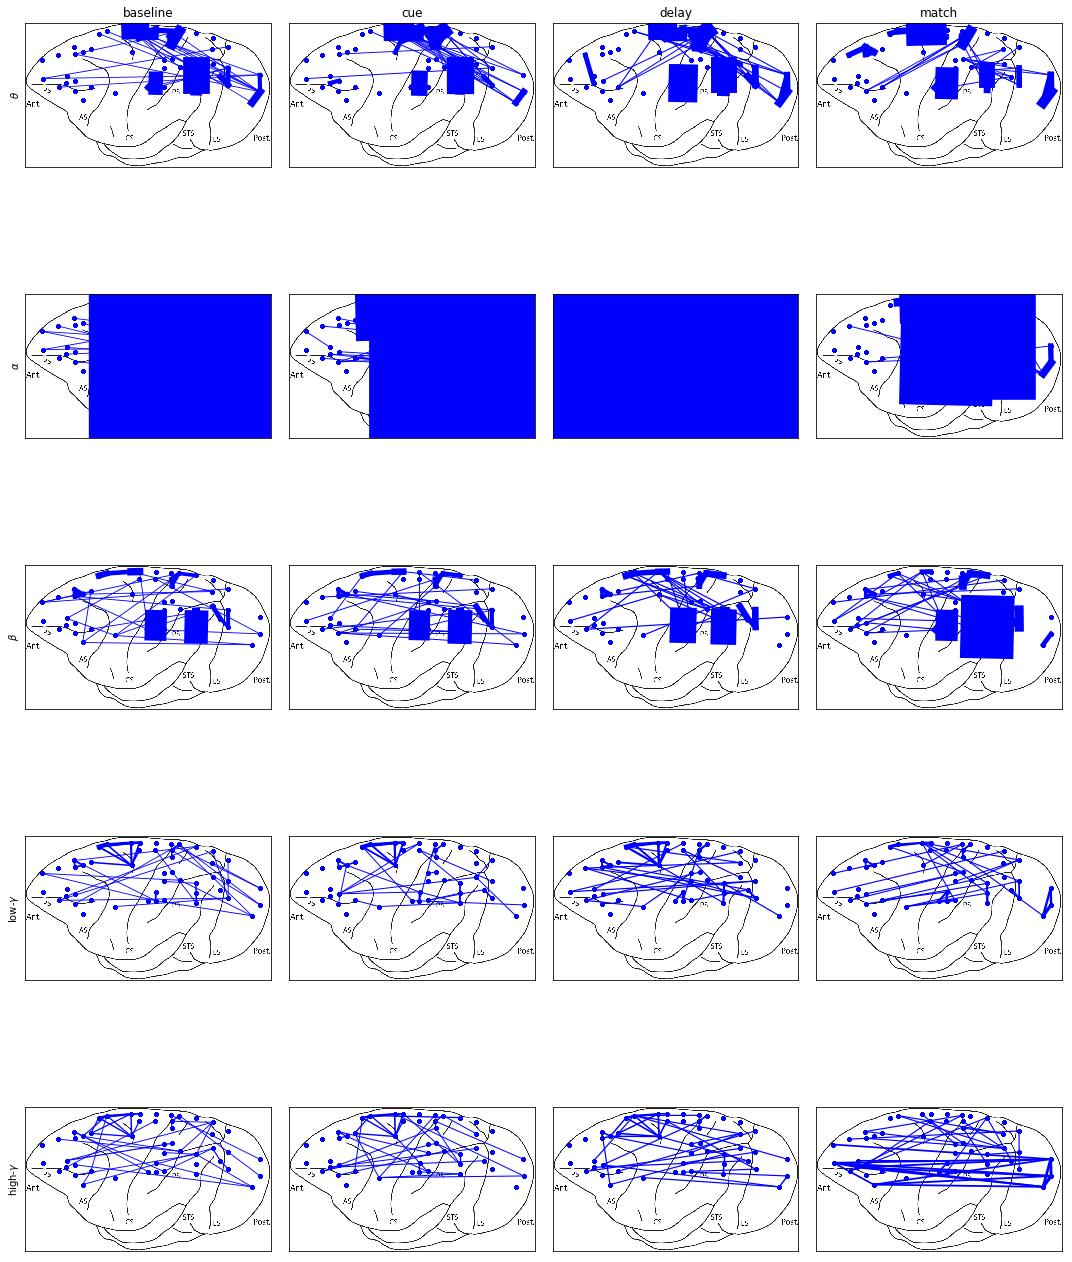

In [19]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,0].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,0].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,0].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,0].shape[0])
        idx2[bot] = 1
        #
        aux = b[stages[i]][:,0]*idx1 - b[stages[i]][:,0]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               .1*aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Top 20 most bursty links

100%|██████████| 5/5 [01:05<00:00, 13.07s/it]


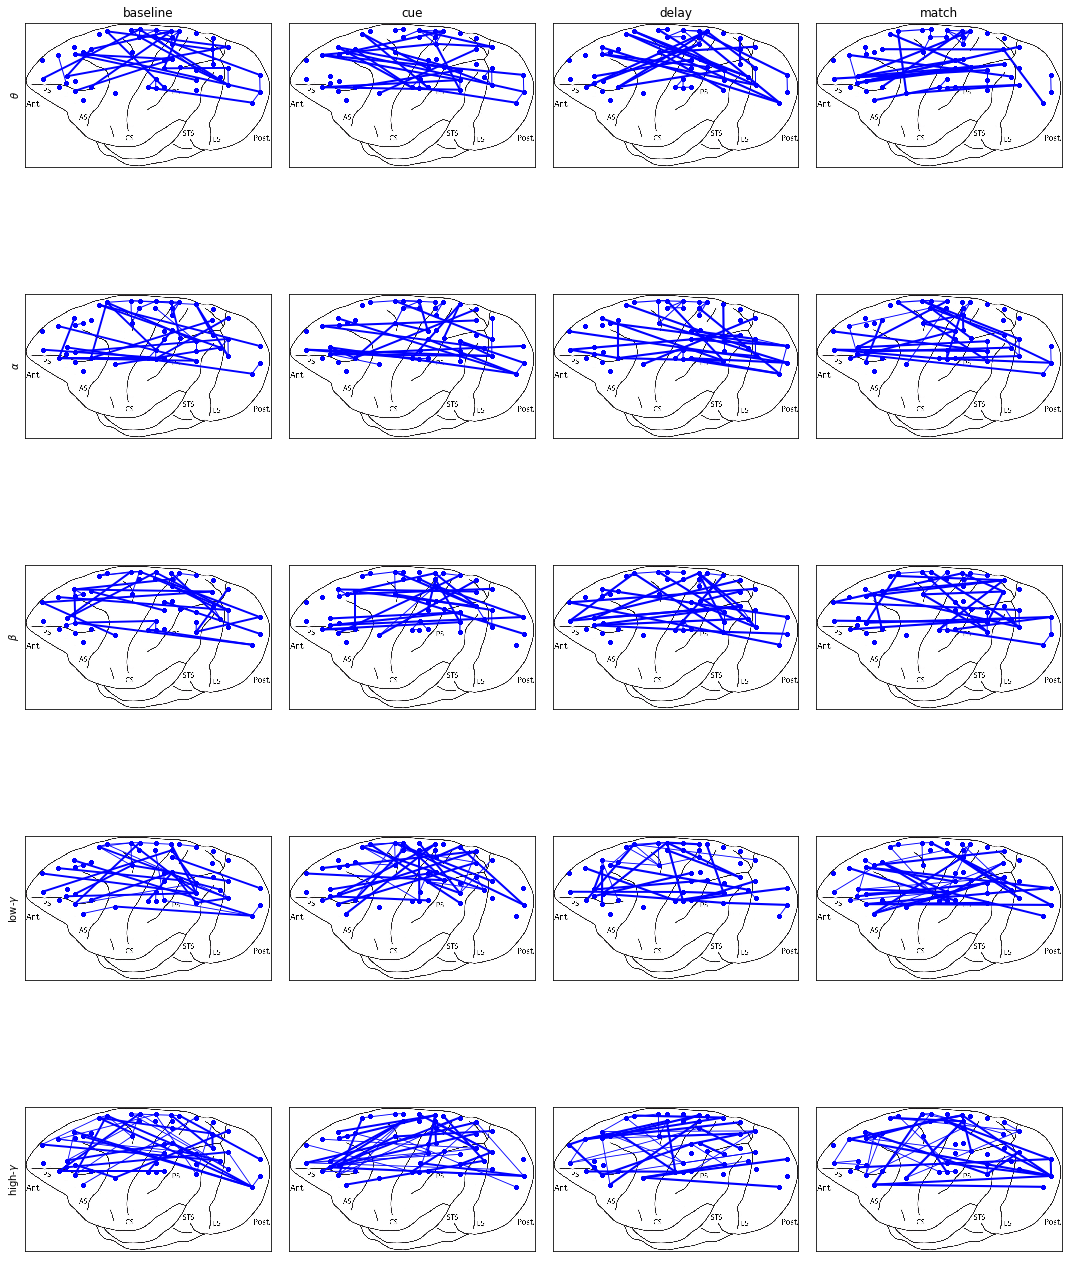

In [20]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,2].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,2].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,2].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,2].shape[0])
        idx2[bot] = 1
        #
        aux = 3*b[stages[i]][:,2]*idx1 - b[stages[i]][:,2]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

In [ ]:
xy   = scipy.io.loadmat('../Brain Areas/lucy_brainsketch_xy.mat')['xy'] # Channels coordinates

In [ ]:
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting
        plt.subplot(len(bands), len(stages), count)
        plt.semilogx(d_eu, b[stages[i]][:,2], 'o')
        plt.ylabel('Link CV')
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()

### Relative threshold

100%|██████████| 4/4 [02:41<00:00, 40.40s/it]


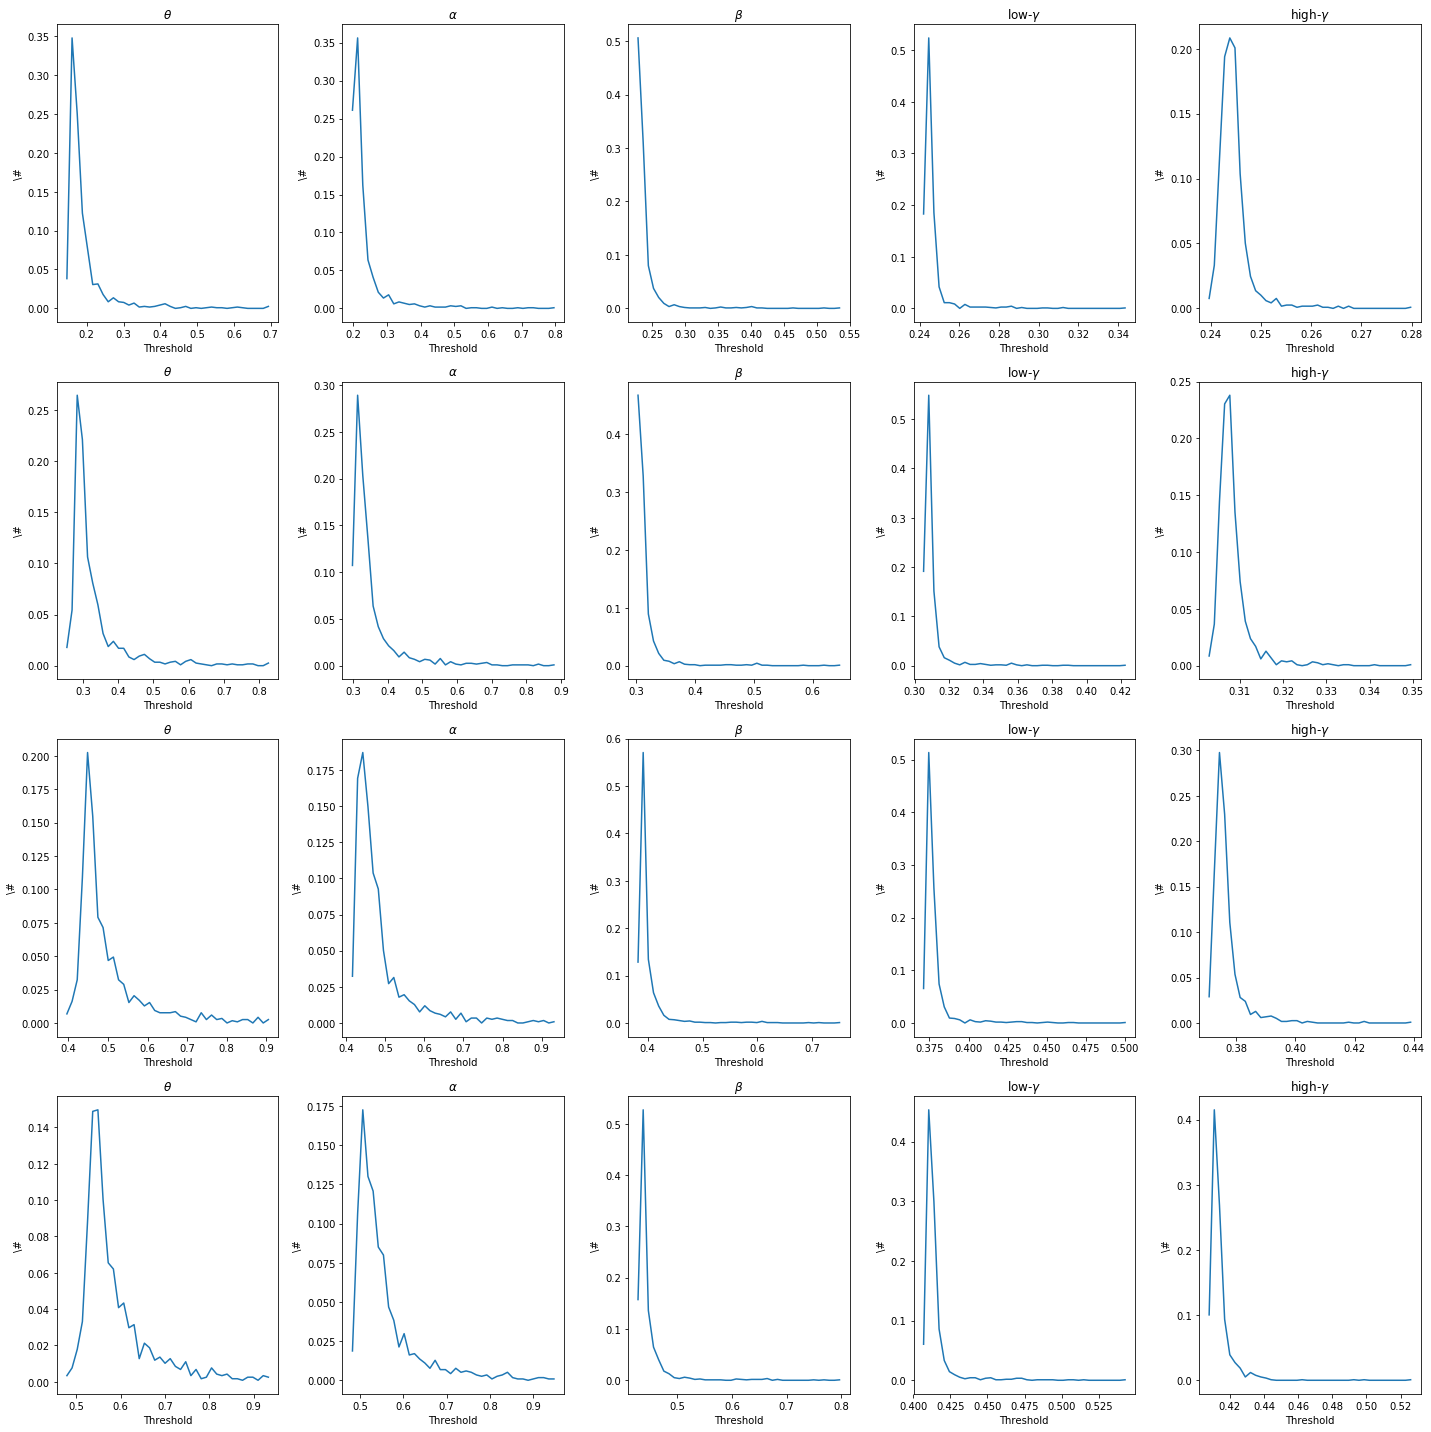

In [9]:
probs = [0.2, 0.5, 0.8, 0.9]
plt.figure(figsize=(20,20))
count = 1
for j in tqdm( range(len(probs)) ):
    for i in range(len(net.bands)):
        plt.subplot(len(probs),len(net.bands),count)
        thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=probs[j], axis=1)
        c, x = np.histogram(thr, 40)
        c    = c/c.sum()
        plt.plot(x[1:], c)
        plt.title(bands[i])
        plt.xlabel('Threshold')
        plt.ylabel('\#')
        count += 1
plt.tight_layout()

In [10]:
scipy.stats.mstats.mquantiles(net.super_tensor[111,1,:], prob=0.20)

array([0.20448273])

In [82]:
# THRESHOLD 
q_thr = .80

In [83]:
STb = np.zeros_like(net.super_tensor)
for i in tqdm( range(len(net.bands)) ):
    thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=q_thr, axis=1)
    STb[:,i,:] = net.super_tensor[:,i,:] > thr

100%|██████████| 5/5 [00:41<00:00,  8.27s/it]


100%|██████████| 5/5 [00:00<00:00, 42.19it/s]


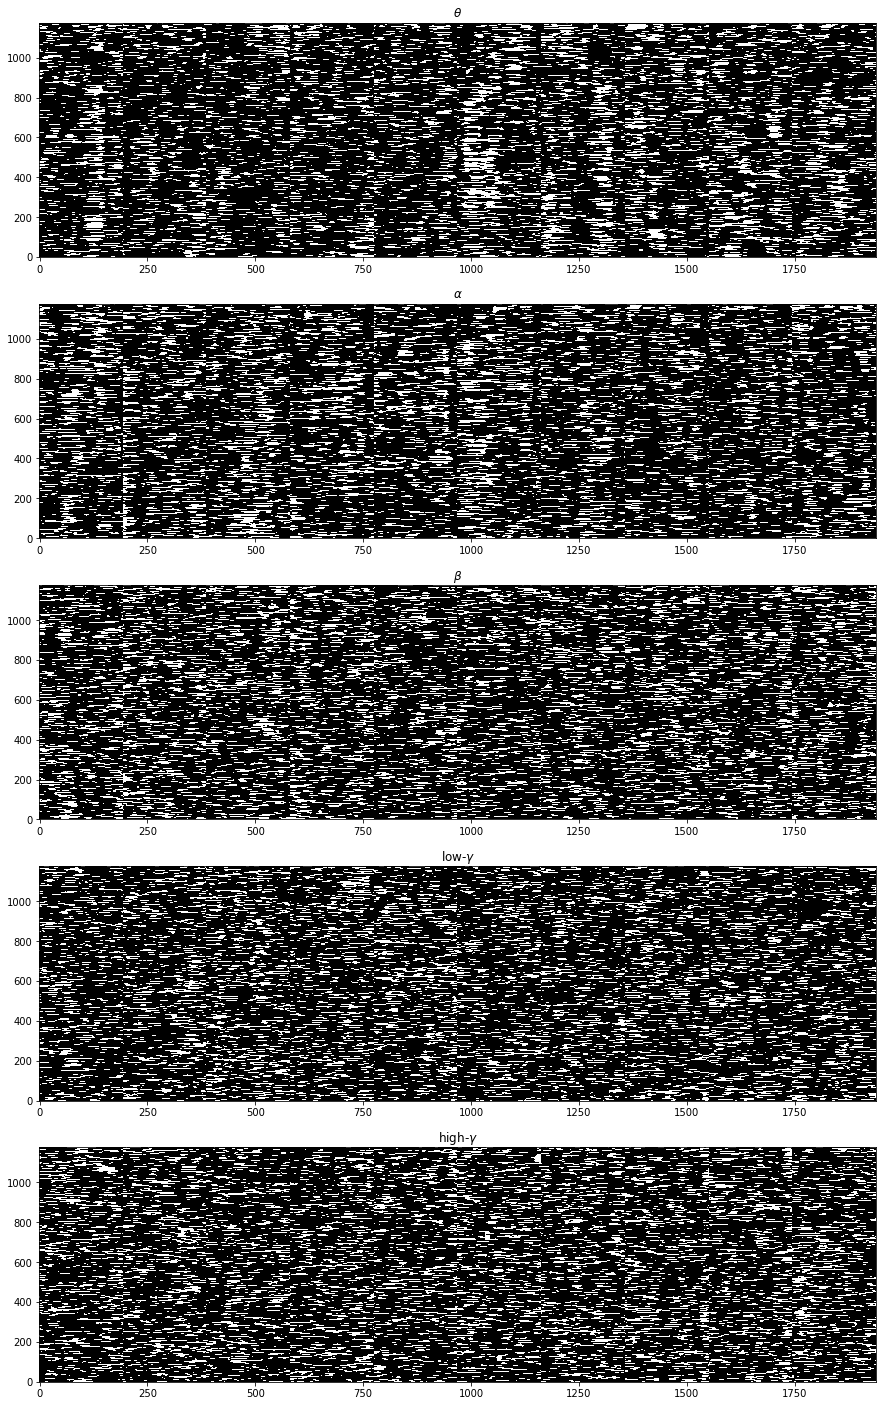

In [84]:
plt.figure(figsize=(15,25))
for i in tqdm( range(len(net.bands)) ):
    #thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=.80, axis=1)
    #a = net.super_tensor[:,i,:] > thr
    plt.subplot(5,1,i+1)
    plt.imshow(STb[:,i,:10*len(net.tarray)], aspect='auto', cmap='gray', origin = 'lower')
    plt.title(bands[i])

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


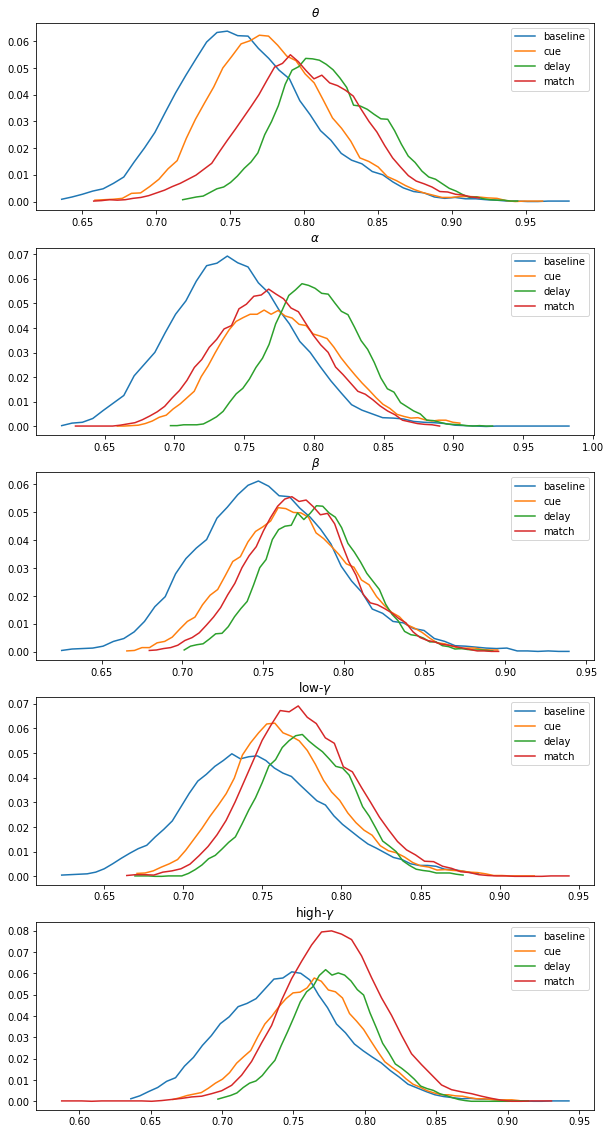

In [85]:
stages = ['baseline', 'cue', 'delay', 'match']
t_mask = [net.t_baseline, net.t_cue, net.t_delay, net.t_match]
plt.figure(figsize=(10,20))
for i in tqdm( range(len(net.bands)) ):
    #thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=.80, axis=1)
    #a = net.super_tensor[:,i,:] > thr
    b  = {}
    plt.subplot(5,1,i+1)
    for j in range(len(stages)):
        b[stages[j]]  = np.zeros([STb.shape[0], 3])
        b[stages[j]]  = np.apply_along_axis( count_activations, 1, STb[:,i,t_mask[j]])
        aux = b[stages[j]][:,1]/b[stages[j]][:,0]
        c, x = np.histogram(aux, 50)
        c    = c/c.sum()
        plt.plot(x[1:], smooth(c,5), label = stages[j])
        plt.legend()
        plt.title(bands[i])

100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


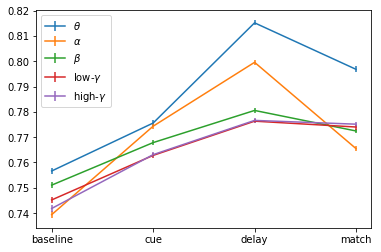

In [86]:
for j in range(len(bands)):
    for i in tqdm(range(len(stages))):
        b[stages[i]]  = np.zeros([STb.shape[0], 3])
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])

    p=b['baseline'][:,2]
    c=b['cue'][:,2]
    d=b['delay'][:,2]
    m=b['match'][:,2]

    plt.errorbar(range(4), [p.mean(), c.mean(), d.mean(), m.mean()], 
                 [p.std()/np.sqrt(1176), c.std()/np.sqrt(1176), d.std()/np.sqrt(1176), m.std()/np.sqrt(1176)])
    plt.xticks(range(4), ['baseline', 'cue', 'delay', 'match'])
plt.legend(bands)

In [87]:
CVm = np.zeros([49, 49, len(bands), len(stages)]) 
b['delay'].shape
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        aux  = np.apply_along_axis( count_activations, 1, STb[:,k,t_mask[i]])
        for j in range( net.session_info['pairs'].shape[0]):
            CVm[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], k, i] = aux[j,2]

100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


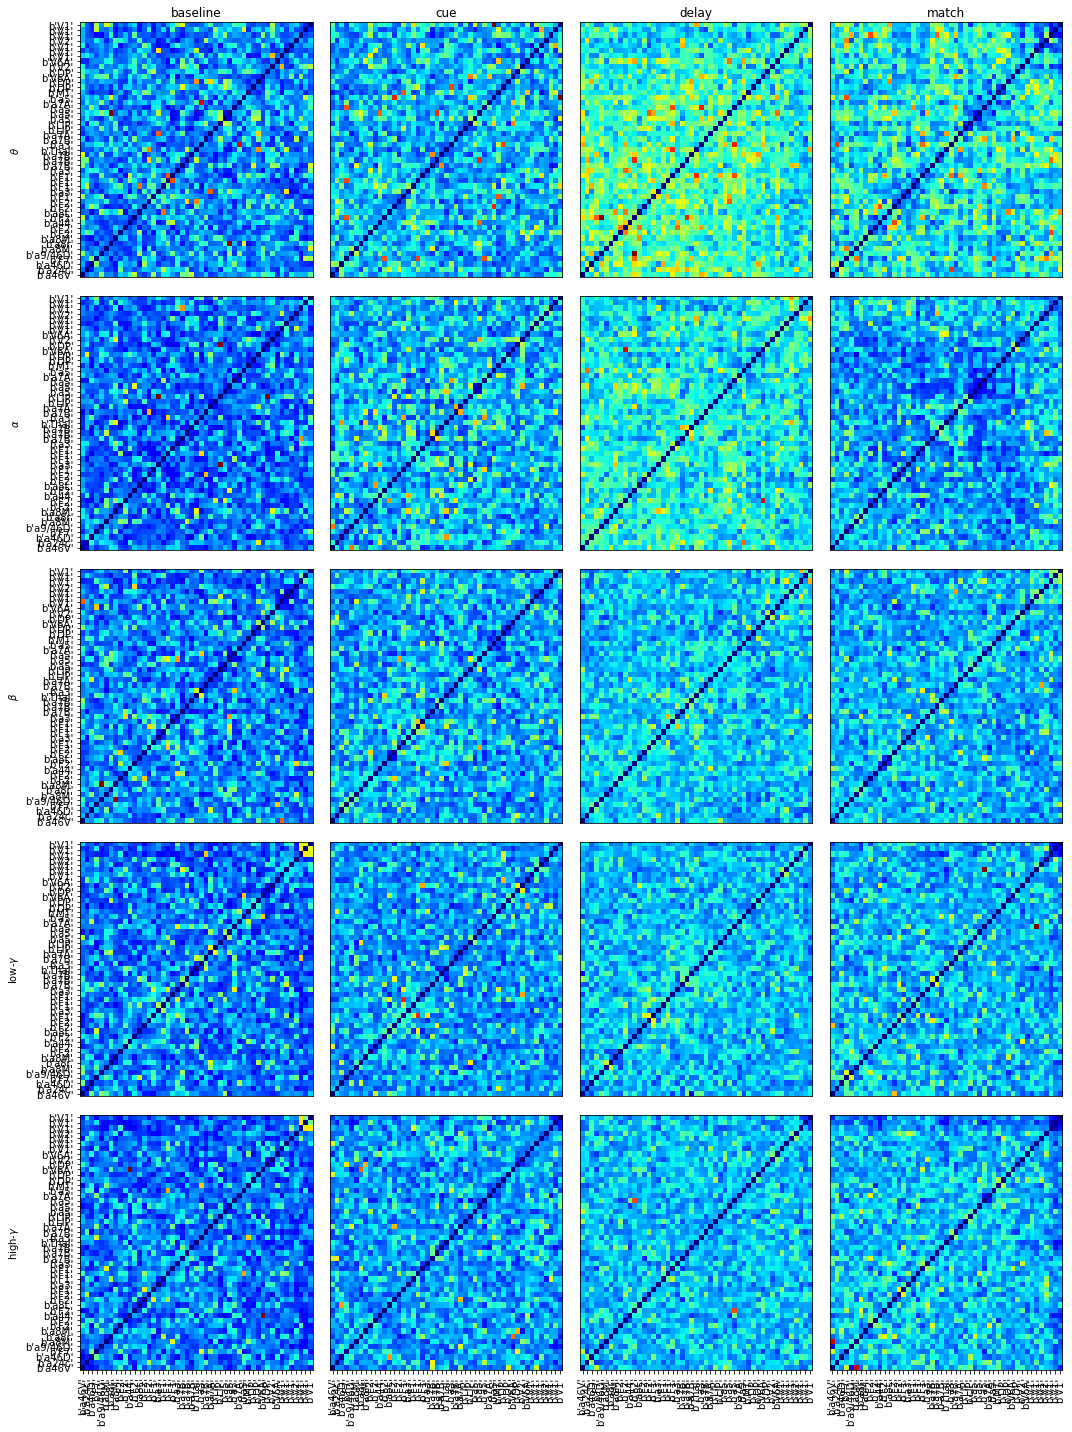

In [88]:
plt.figure(figsize=(15,20))
count = 1
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(bands),len(stages),count)
        aux = (CVm[:,:,k,i]+CVm[:,:,k,i].T) 
        plt.imshow(aux**6, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=.7)
        if stages[i] == 'baseline': plt.yticks(range(49), net.session_info['areas'])
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), net.session_info['areas'], rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[k])
        #plt.colorbar()
        count+=1
plt.tight_layout()

#### Top 20 most active links

100%|██████████| 5/5 [01:08<00:00, 13.77s/it]


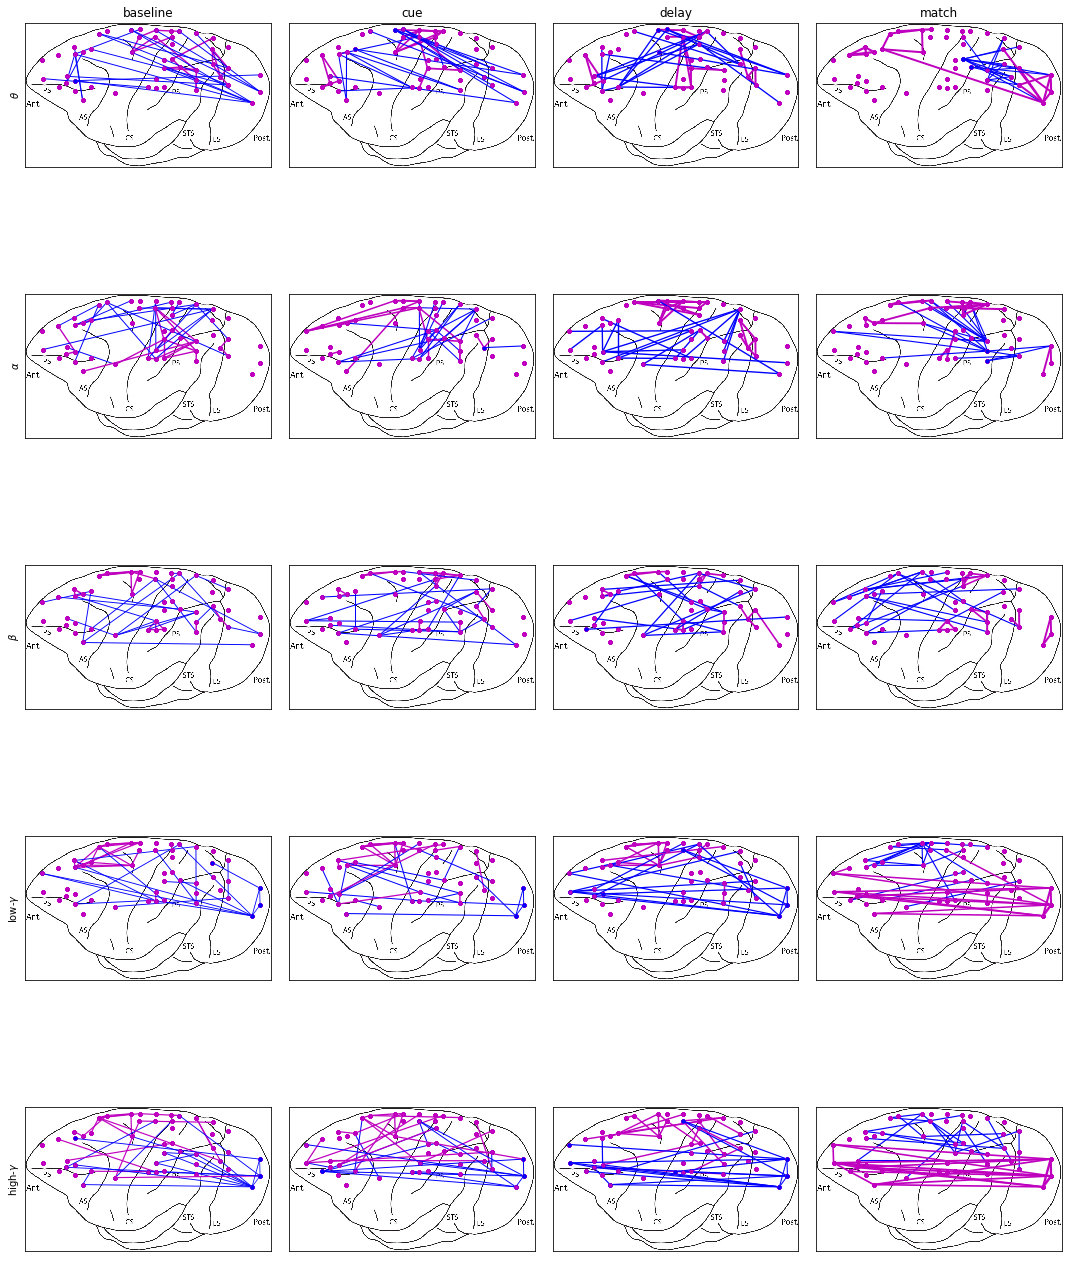

In [24]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,0].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,0].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,0].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,0].shape[0])
        idx2[bot] = 1
        #
        aux = b[stages[i]][:,0]*idx1 - b[stages[i]][:,0]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               .1*aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Top 20 most busrty links

100%|██████████| 5/5 [01:08<00:00, 13.71s/it]


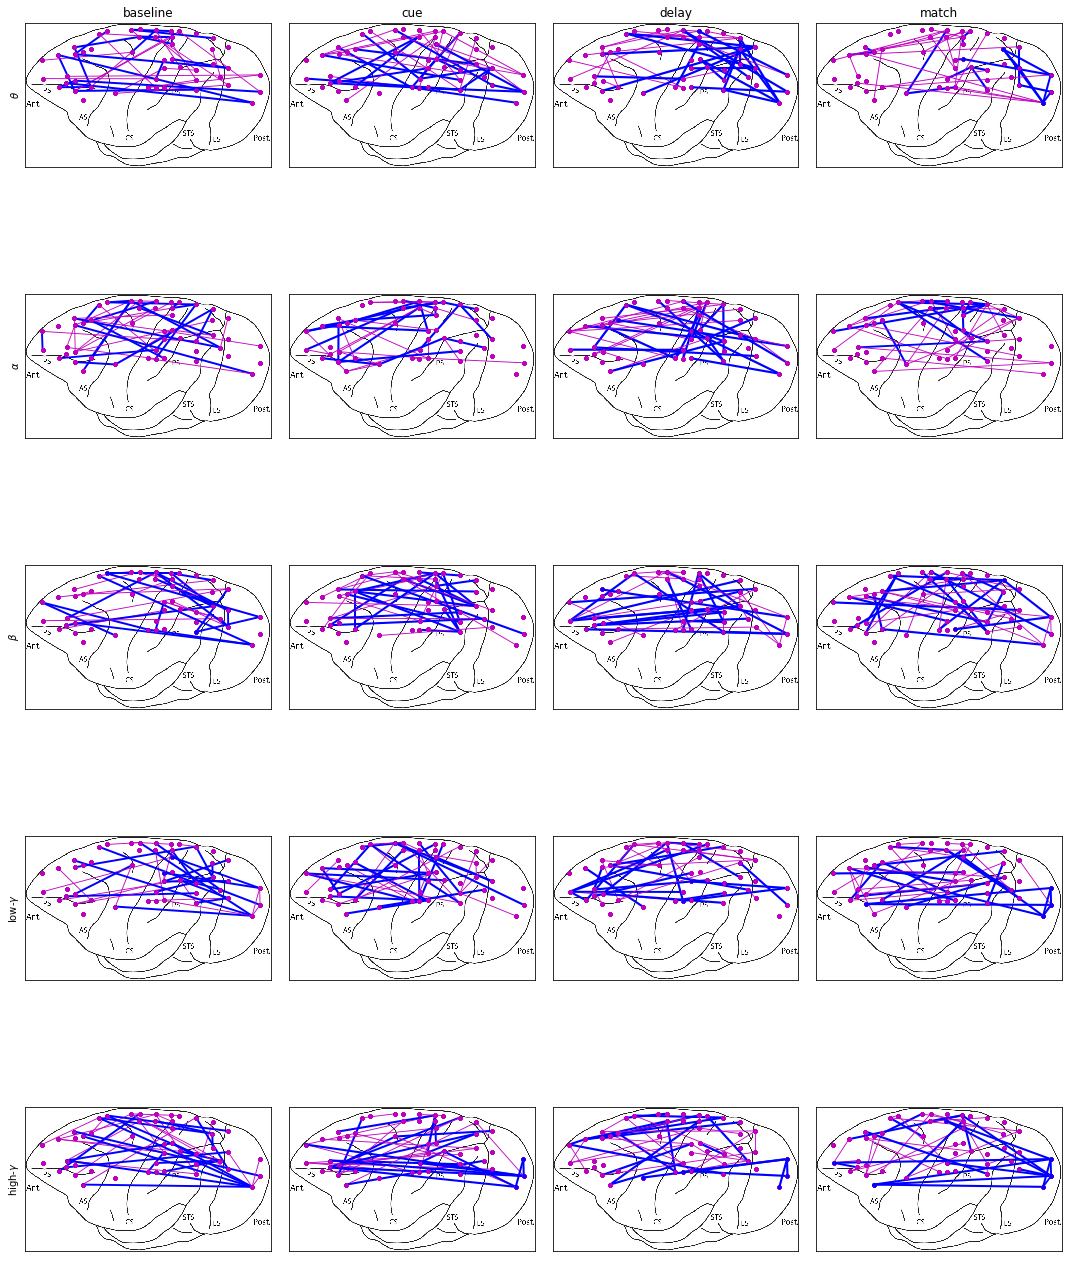

In [25]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,2].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,2].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,2].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,2].shape[0])
        idx2[bot] = 1
        #
        aux = 3*b[stages[i]][:,2]*idx1 - b[stages[i]][:,2]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Burstness vs active time

100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


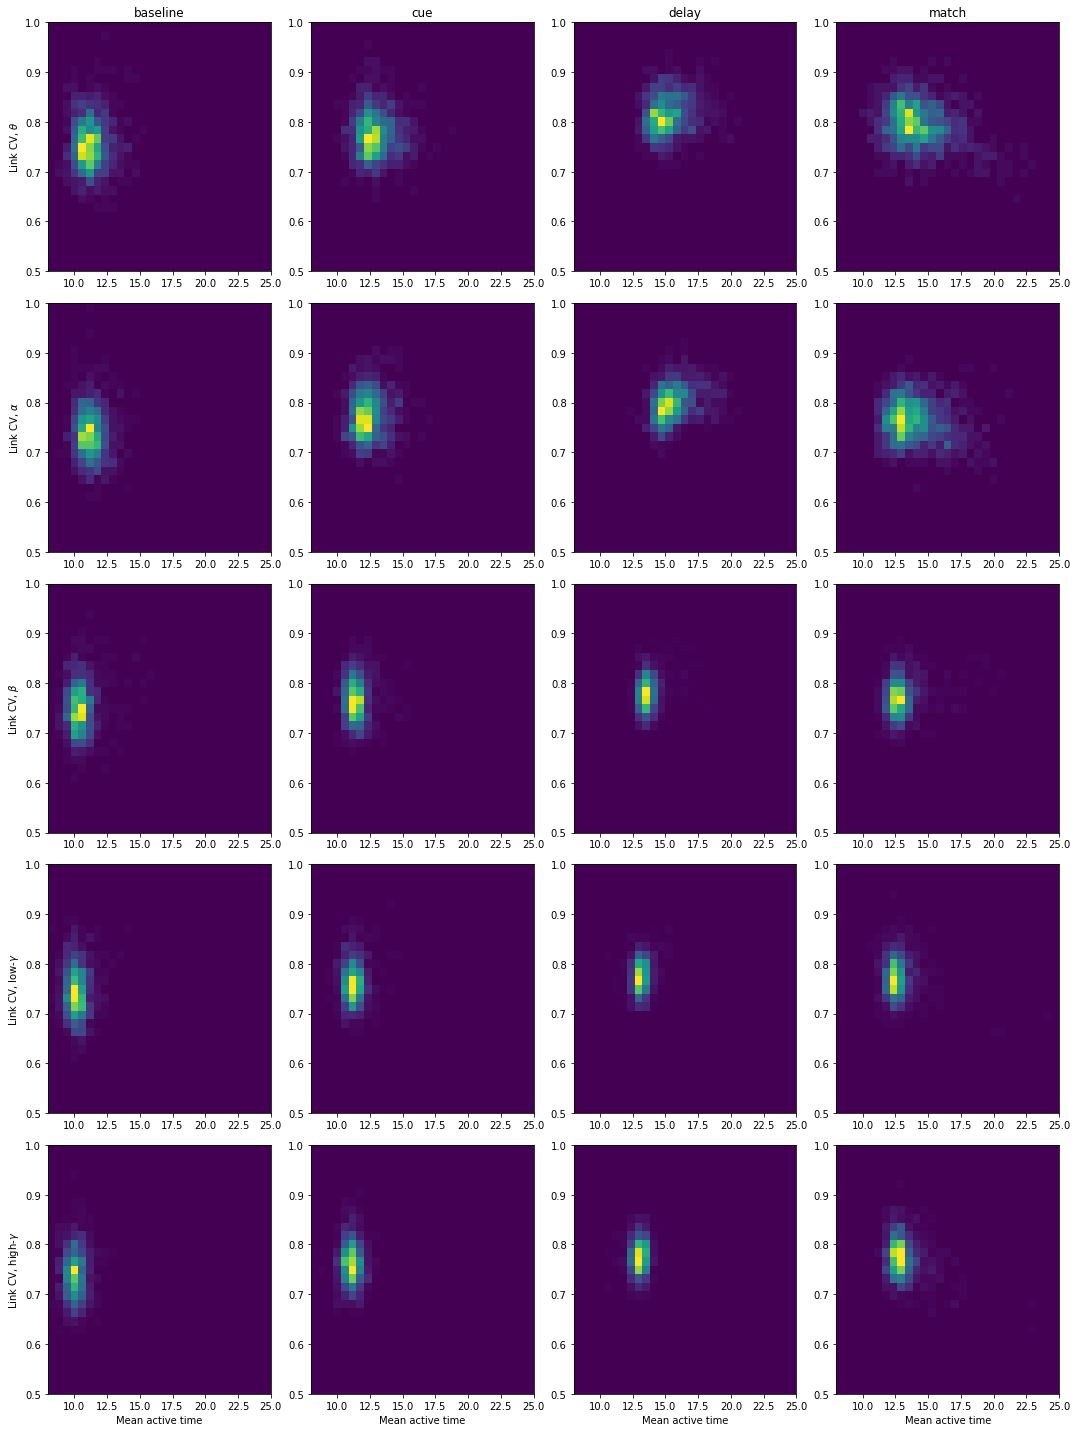

In [26]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        plt.hist2d(b[stages[i]][:,0], b[stages[i]][:,2], bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)] )
        if j == 4: plt.xlabel('Mean active time')
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel('Link CV, ' + bands[j])
        count += 1
plt.tight_layout()

#### Links' rates

In [62]:
r = np.zeros([len(bands), STb.shape[-1]])
for i in tqdm(range(len(bands))):
    r[i,:] = STb[:,i,:].sum(axis=0)

100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


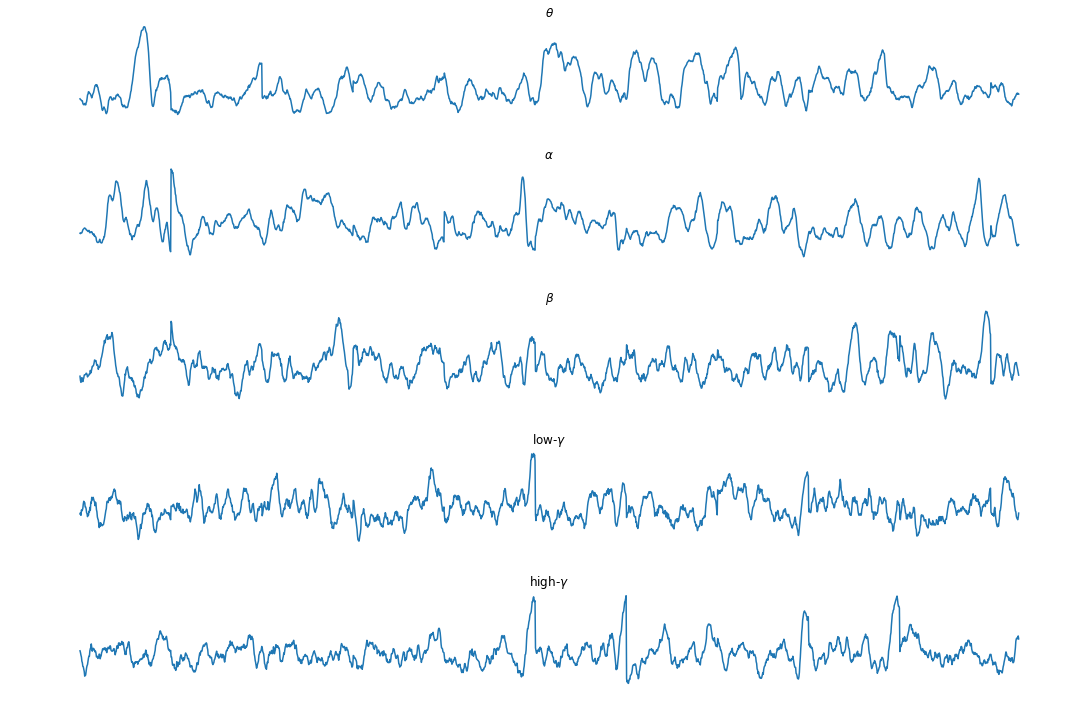

In [71]:
plt.figure(figsize=(15,10))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.plot(r[i,:2000])
    plt.title(bands[i])
    plt.axis('off')
plt.tight_layout()

100%|██████████| 5/5 [00:00<00:00, 54.08it/s]


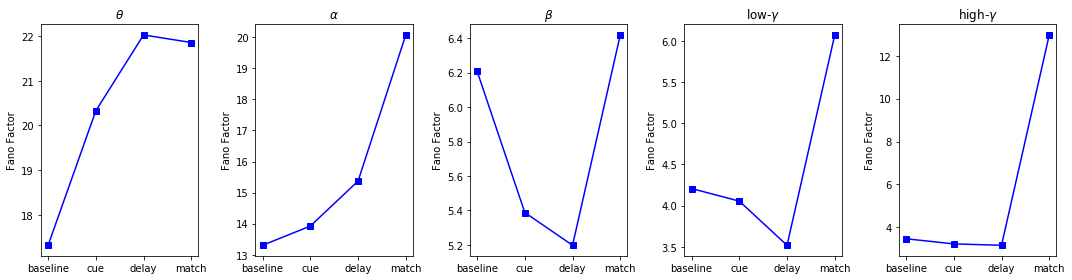

In [28]:
plt.figure(figsize=(15,4))
count = 1
ff  = np.zeros([len(bands), len(stages)])
for j in tqdm( range(len(bands)) ):
    plt.subplot(1, len(bands), count)
    for i in range(len(stages)):
        ff[j,i] = r[j,t_mask[i]].var() / r[j,t_mask[i]].mean() 
    plt.plot(ff[j,:], 'bs-')
    plt.ylabel('Fano Factor')
    plt.title(bands[j])
    plt.xticks(range(4), stages)
    count += 1
plt.tight_layout()

#### Dimensinality reduction on the raster plots

In [20]:
from MulticoreTSNE    import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

In [40]:
#tsne = TSNE(n_jobs=40)
#Y = tsne.fit_transform(STb[:,1,:10*194].T)
Y = TSNE(n_components=2, metric='hamming', perplexity=30.0).fit_transform(STb[:,1,:20*194].T)

In [41]:
Y.shape

(3880, 2)

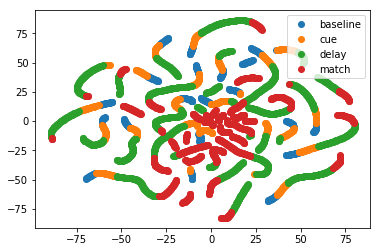

In [42]:
for i in range(len(stages)):
    plt.plot(Y[t_mask[i][:20*194],0], Y[t_mask[i][:20*194],1], 'o', label = stages[i])
plt.legend()

100%|██████████| 4/4 [01:51<00:00, 27.82s/it]


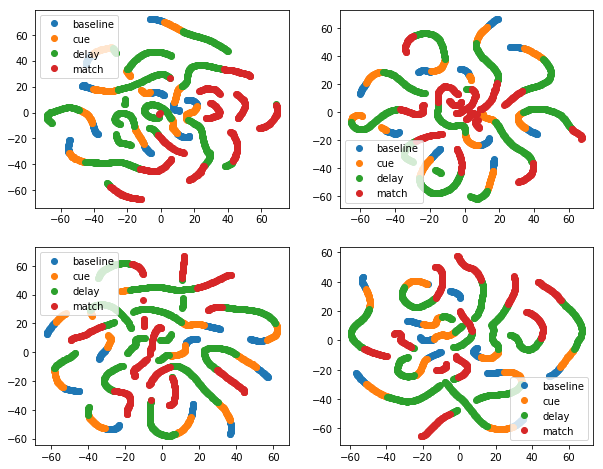

In [45]:
plt.figure(figsize=(10,8))
for i in tqdm( range(len(bands)-1) ):
    Y = TSNE(n_components=2, metric='hamming', perplexity=30.0).fit_transform(STb[:,i,:10*194].T)
    plt.subplot(2,2,i+1)
    for j in range(len(stages)):
        plt.plot(Y[t_mask[j][:10*194],0], Y[t_mask[j][:10*194],1], 'o', label = stages[j])
    if j == 3: plt.legend()
    plt.title()

#### Burstiness vs electrode distance

In [47]:
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


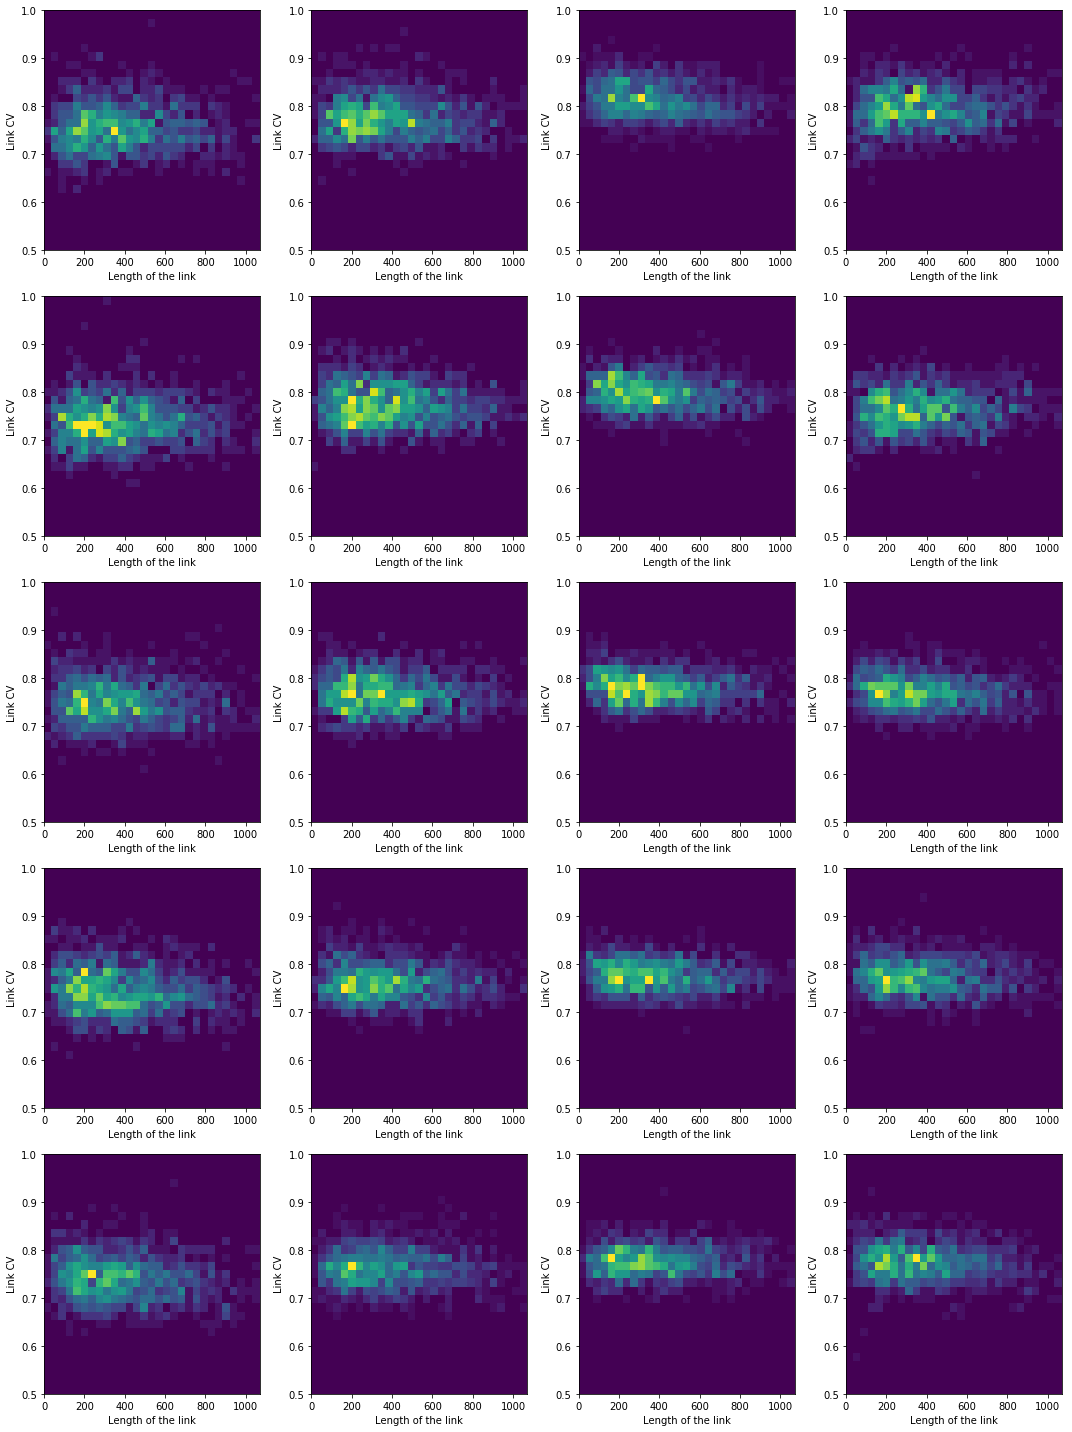

In [53]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting
        plt.subplot(len(bands), len(stages), count)
        plt.hist2d(d_eu, b[stages[i]][:,2], bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)])
        plt.ylabel('Link CV')
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()

#### Links' correlation

In [51]:
STb[:,1,:].shape

(1176, 104760)

In [80]:
M = np.corrcoef()

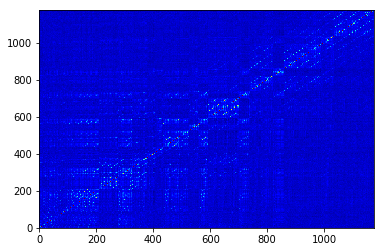

In [77]:
plt.imshow(M, aspect='auto', cmap='jet', origin='lower')

In [99]:
cc = np.zeros([4,1176, 1176])
for s in tqdm( range(len(stages)) ):
    aux = STb[:,4,t_mask[s]]
    for i, j in pairs:
        cc[s,i,j] = np.dot( aux[i], aux[j] ) / aux.shape[-1]
        #cc[s,j,i] = np.dot( aux[i], aux[j] ) / aux.shape[-1]

100%|██████████| 4/4 [03:21<00:00, 50.47s/it]


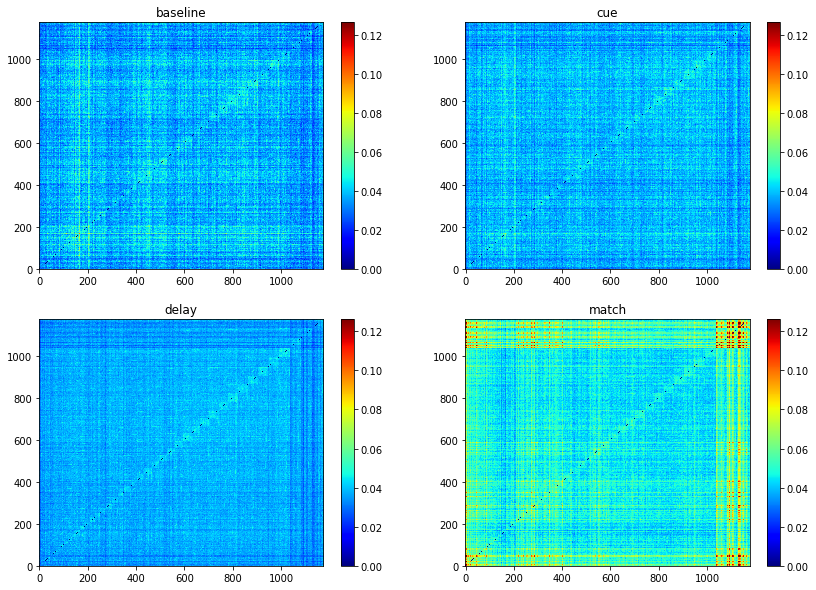

In [100]:
plt.figure(figsize=(14,10))
for i in range(len(stages)):
    plt.subplot(2,2,i+1)
    plt.imshow(cc[i,:,:]+cc[i,:,:].T, aspect='auto', cmap='jet', origin='lower', vmax=cc.max()/3)
    plt.title(stages[i])
    plt.colorbar()